# PII Data Detection

## Data & Imports

### Library Imports

In [ ]:
 !pip install seqeval evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 27.9 MB/s eta 0:00:00


In [ ]:
 !pip install torch -q

In [ ]:
 !pip install tensorflow -q

In [ ]:
 !pip install transformers datasets features -q

In [ ]:
 !pip install sentencepiece -q

In [ ]:
 !pip install accelerate -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
import json
import argparse
from itertools import chain
from functools import partial

import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
import evaluate
from datasets import Dataset, features
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
import plotly.express as px

### Dataset imports

In [ ]:
# data = json.load(open("datasets/train.json"))

# # downsampling of negative examples
# p=[] # positive samples (contain relevant labels)
# n=[] # negative samples (presumably contain entities that are possibly wrongly classified as entity)
# for d in data:
#     if any(np.array(d["labels"]) != "O"): p.append(d)
#     else: n.append(d)
# original_data = data
# print("original datapoints: ", len(data))

# external = json.load(open("datasets/pii_dataset_fixed.json"))
# print("external datapoints: ", len(external))

# moredata = json.load(open("datasets/moredata_dataset_fixed.json"))
# print("moredata datapoints: ", len(moredata))

# data = p+n[:len(n)//3]+moredata+external
# print("combined: ", len(data))

### Datasets imports (Google Collab)

In [ ]:
import os
import json
import numpy as np
from google.colab import drive

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    # base_path = '/content/drive/My Drive/2024-Spring/MSCS-PROJECT/jupyter-notebooks/'
    base_path = '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/'
    train_data_path = base_path + "datasets/train.json"
    pii_data_path = base_path + "datasets/pii_dataset_fixed.json"
    moredata_data_path = base_path + "datasets/moredata_dataset_fixed.json"
    test_data_path = base_path + "datasets/test.json"
else:
    current_dir = os.getcwd()

    train_data_path = os.path.join(current_dir, "datasets", "train.json")
    pii_data_path = os.path.join(current_dir, "datasets", "pii_dataset_fixed.json")
    moredata_data_path = os.path.join(current_dir, "datasets", "moredata_dataset_fixed.json")
    test_data_path = os.path.join(current_dir, "datasets", "test.json")

data = json.load(open(train_data_path))

p = []
n = []
for d in data:
    if any(np.array(d["labels"]) != "O"):
        p.append(d)
    else:
        n.append(d)

original_data = data
print("original datapoints: ", len(data))

external = json.load(open(pii_data_path))
print("external datapoints: ", len(external))

moredata = json.load(open(moredata_data_path))
print("moredata datapoints: ", len(moredata))

data = p + n[:len(n) // 3] + moredata + external
print("combined: ", len(data))

print('-'*20)

test_data = json.load(open(test_data_path))
# print("test data: ", len(test_data))

Mounted at /content/drive
original datapoints:  6807
external datapoints:  4434
moredata datapoints:  2000
combined:  9333
--------------------


### Data Analysis

In [ ]:
df_og = pd.DataFrame(original_data)

def encode_labels(df_og):
  df_og["unique_labels"] = df_og["labels"].apply(lambda x: list(set(
      [l.split('-')[1] for l in x if l != 'O']
      )))

  from sklearn.preprocessing import MultiLabelBinarizer

  mlb = MultiLabelBinarizer()
  one_hot_encoded = mlb.fit_transform(df_og['unique_labels'])
  one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
  df_og = pd.concat([df_og, one_hot_df], axis=1)

  df_og['OTHER'] = df_og['unique_labels'].apply(lambda x: 1 if len(x) == 0 else 0)

  return df_og, list(mlb.classes_) + ['OTHER']

In [ ]:
df_og, label_classes = encode_labels(df_og)

for col in label_classes:
  print(f'{col}: {df_og[col].sum()}')

EMAIL: 24
ID_NUM: 33
NAME_STUDENT: 891
PHONE_NUM: 4
STREET_ADDRESS: 2
URL_PERSONAL: 72
USERNAME: 5
OTHER: 5862


### Data Visualization & Label Mapping

In [ ]:
df = pd.DataFrame(data)
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
9328,ffacbfa2-fd35-4ac1-b975-a2cc41f56544,"During my 15-year career as a developer, I hav...","[During, my, 15, -, year, career, as, a, devel...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9329,ffdecdd0-cd86-4281-9271-1dfe26d4a790,"In 2019, a particularly challenging case came ...","[In, 2019, ,, a, particularly, challenging, ca...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9330,ffdf4428-e76f-4465-9fba-60d5685096f7,"Hello there, I'm Krishna Lopez and I've been a...","[Hello, there, ,, I, 'm, Krishna, Lopez, and, ...","[True, False, True, False, True, True, True, T...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
9331,ffdfbd65-978c-49e8-88ce-b726ce95b26b,"As a designer, I've encountered various challe...","[As, a, designer, ,, I, 've, encountered, vari...","[True, True, False, True, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
def json_to_df_with_id(data):
    dfs = []

    for document in data:
        doc_id = document['document']
        tokens = document['tokens']
        trailing_whitespace = document['trailing_whitespace']
        labels = document['labels']

        df = pd.DataFrame({
            'Document ID': doc_id,
            'Token': tokens,
            'Trailing Whitespace': trailing_whitespace,
            'Label': labels
        })

        dfs.append(df)

    combined_df_with_id = pd.concat(dfs, ignore_index=True)

    return combined_df_with_id

df_data = json_to_df_with_id(data)
df_data

,Document ID,Token,Trailing Whitespace,Label
0,7,Design,True,O
1,7,Thinking,True,O
2,7,for,True,O
3,7,innovation,True,O
4,7,reflexion,False,O
...,...,...,...,...
4807199,fff794fe-d3f7-4452-b704-2714c24337ef,Hiroko,True,B-NAME_STUDENT
4807200,fff794fe-d3f7-4452-b704-2714c24337ef,Yu,True,I-NAME_STUDENT
4807201,fff794fe-d3f7-4452-b704-2714c24337ef,725,True,B-STREET_ADDRESS
4807202,fff794fe-d3f7-4452-b704-2714c24337ef,65th,True,I-STREET_ADDRESS


In [ ]:
# csv_file_path = base_path + "/outputs/input.csv"
# df_data.to_csv(csv_file_path, index=False)

# from google.colab import files
# files.download(csv_file_path)

In [ ]:
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

original_labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
          "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
          "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
          "I-STREET_ADDRESS","I-URL_PERSONAL","O"]

target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM',
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM',
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

print('all_labels: ', all_labels)
print('label2id: ',label2id)
print('id2label: ',id2label)

all_labels:  ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']
label2id:  {'B-EMAIL': 0, 'B-ID_NUM': 1, 'B-NAME_STUDENT': 2, 'B-PHONE_NUM': 3, 'B-STREET_ADDRESS': 4, 'B-URL_PERSONAL': 5, 'B-USERNAME': 6, 'I-ID_NUM': 7, 'I-NAME_STUDENT': 8, 'I-PHONE_NUM': 9, 'I-STREET_ADDRESS': 10, 'I-URL_PERSONAL': 11, 'O': 12}
id2label:  {0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}


In [ ]:
words = np.empty(len(data), dtype=object)
labels = np.empty(len(data), dtype=object)

for i, x in tqdm(enumerate(data), total=len(data)):
    words[i] = np.array(x["tokens"])
    labels[i] = np.array([label2id[label] for label in x["labels"]])

  0%|          | 0/9333 [00:00<?, ?it/s]

In [ ]:
all_labels_np = np.array([x for label in labels for x in label])
unique_labels, label_counts = np.unique(all_labels_np, return_counts=True)

fig = go.Figure(data=go.Bar(x=original_labels, y=label_counts))
fig.update_layout(
    title="Label Distribution",
    xaxis_title="Labels",
    yaxis_title="Count",
    yaxis_type="log",
)

fig.update_traces(text=label_counts, textposition="outside")
fig.show()

### More Visualization

In [ ]:
import polars as pl
import spacy
from spacy.tokens import Span
from spacy import displacy

In [ ]:
options = {
    "colors": {
        "B-NAME_STUDENT": "aqua",
        "I-NAME_STUDENT": "skyblue",
        "B-EMAIL": "limegreen",
        "I-EMAIL": "lime",
        "B-USERNAME": "hotpink",
        "I-USERNAME": "lightpink",
        "B-ID_NUM": "purple",
        "I-ID_NUM": "rebeccapurple",
        "B-PHONE_NUM": "red",
        "I-PHONE_NUM": "salmon",
        "B-URL_PERSONAL": "silver",
        "I-URL_PERSONAL": "lightgray",
        "B-STREET_ADDRESS": "brown",
        "I-STREET_ADDRESS": "chocolate",
    }
}

In [ ]:
train_v = pl.DataFrame(original_data)

documents_v = train_v.get_column("document").to_list()
full_texts_v = train_v.get_column("full_text").to_list()
labels_v = train_v.get_column("labels").to_list()

In [ ]:
class PllLabelRenderer:
    def __init__(
        self,
        documents_v: list[str],
        full_texts_v: list[str],
        labels_v: list[str],
        options: dict[str, dict[str, str]],
    ) -> None:
        self.nlp = spacy.blank("en")
        self.documents_v = documents_v
        self.full_texts_v = full_texts_v
        self.labels_v = labels_v
        self.options = options

    def render(
        self, render_idx: int | None = None, documents_id: int | None = None
    ) -> None:
        if render_idx and documents_id:
            raise Exception("Don't Use Both render_idx and documents_id")
        if documents_id:
            render_idx = self.documents_v.index(documents_id)
        doc = self.nlp(self.full_texts_v[render_idx])
        doc.ents = [
            Span(doc, idx, idx + 1, label=label)
            for idx, label in enumerate(self.labels_v[render_idx])
            if label != "O"
        ]
        displacy.render(doc, style="ent", jupyter=True, options=options)

In [ ]:
PLR = PllLabelRenderer(
    documents_v=documents_v, full_texts_v=full_texts_v, labels_v=labels_v, options=options
)

In [ ]:
PLR.render(render_idx=0)

In [ ]:
PLR.render(documents_id=9854)

In [ ]:
PLR.render(render_idx=67)

## Classifiers

#### ***Imports***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.metrics import (classification_report, confusion_matrix, f1_score, matthews_corrcoef,
                             precision_recall_curve, precision_score, recall_score, roc_curve, auc, accuracy_score)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, GRU, LSTM, SpatialDropout1D, Bidirectional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant

#### ***Sampled Data***

In [ ]:
sampled_df = df_data.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), 500)))

sampled_df

,Document ID,Token,Trailing Whitespace,Label
3602659,396eec9b-f8a7-499d-a8ed-257866f48bfe,manchu_chen@aol.gov,True,B-EMAIL
2965007,pj_518,thernandez@hotmail.com,True,B-EMAIL
2824952,pj_267,brownguy@gmail.com,False,B-EMAIL
3085321,pj_730,whitekelly@gmail.com,False,B-EMAIL
4378264,b7e4fcae-5044-41ca-912f-7f502bab356f,sabrina-petrov@aol.net,True,B-EMAIL
...,...,...,...,...
4410785,bd35bdd7-2da1-44de-a3f9-73e3c4da2538,that,True,O
3521189,2cffbc6e-00bc-41d1-b55d-0d9644a49acd,One,True,O
470417,8894,\n\n,False,O
4062497,82f8f771-35cd-4a05-9c76-ed43ee5d07de,proud,True,O


In [ ]:
# csv_file_path = base_path + "/outputs/input_sampled_df.csv"
# df_data.to_csv(csv_file_path, index=False)

# from google.colab import files
# files.download(csv_file_path)

In [ ]:
sampled_df.describe()

,Document ID,Token,Trailing Whitespace,Label
count,6007,6007,6007,6007
unique,3522,4207,2,13
top,pj_576,-,False,B-EMAIL
freq,10,368,3537,500


In [ ]:
X_sampled = sampled_df['Token']
y_sampled = sampled_df['Label']

print(X_sampled.head())
print(y_sampled.head())

3602659       manchu_chen@aol.gov
2965007    thernandez@hotmail.com
2824952        brownguy@gmail.com
3085321      whitekelly@gmail.com
4378264    sabrina-petrov@aol.net
Name: Token, dtype: object
3602659    B-EMAIL
2965007    B-EMAIL
2824952    B-EMAIL
3085321    B-EMAIL
4378264    B-EMAIL
Name: Label, dtype: object



#### ***Logistic Regression (with POS Tagging)***


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



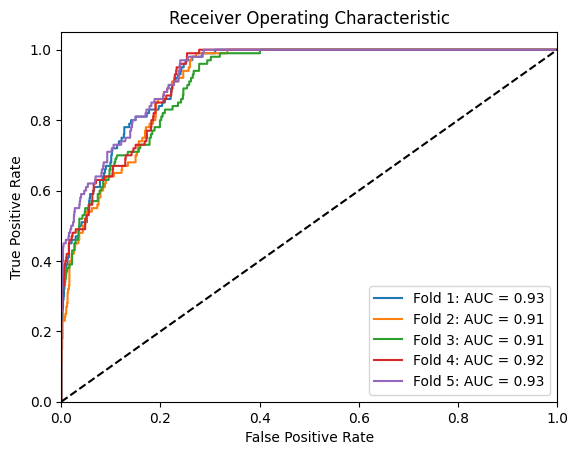

Average MCC: 0.6037237778110975
Average Recall: 0.5866153846153846
Average Precision: 0.5993604578952132
Average Accuracy: 0.6347637368194281
Average F1 Score: 0.5817925113897287
Average ROC AUC: 0.9205487331266247


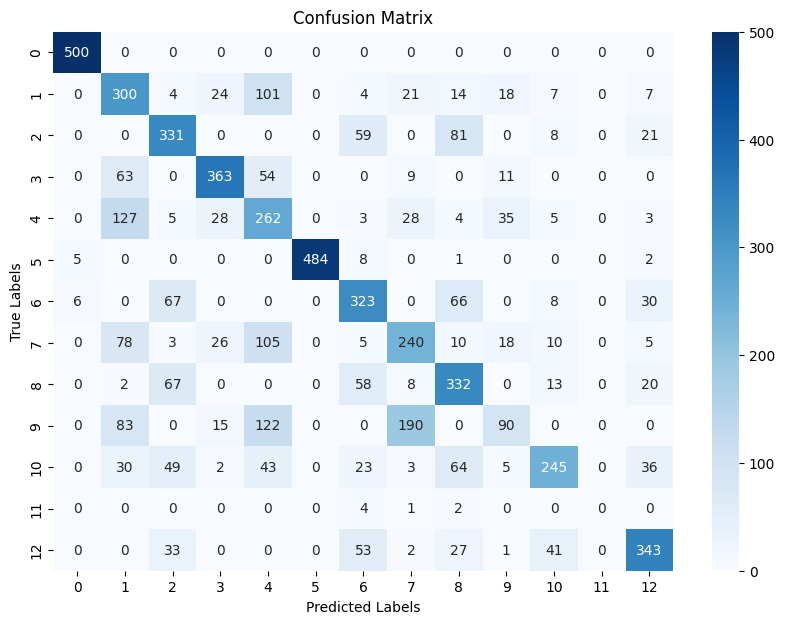

In [ ]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve, matthews_corrcoef, recall_score, precision_score, accuracy_score, f1_score
import seaborn as sns

nlp_lr_exp = spacy.load("en_core_web_sm")

def add_pos_tags_lr_exp(text):
    doc = nlp_lr_exp(text)
    return " ".join([f"{token.text}_{token.pos_}" for token in doc])

exp_sampled_df = df_data.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), 500)))
exp_X_sampled = exp_sampled_df['Token'].apply(lambda x: ' '.join(x))
exp_y_sampled = exp_sampled_df['Label']

exp_X_sampled_pos = [add_pos_tags_lr_exp(text) for text in exp_X_sampled]
exp_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1, 3))
exp_X_vectorized_sampled = exp_vectorizer.fit_transform(exp_X_sampled_pos)

exp_skf = StratifiedKFold(n_splits=5)
exp_mcc_scores, exp_recall_scores, exp_precision_scores, exp_accuracy_scores, exp_roc_auc_scores, exp_f1_scores = [], [], [], [], [], []
all_exp_y_test, all_exp_predictions = [], []

for train_index, test_index in exp_skf.split(exp_X_vectorized_sampled, exp_y_sampled):
    exp_X_train, exp_X_test = exp_X_vectorized_sampled[train_index], exp_X_vectorized_sampled[test_index]
    exp_y_train, exp_y_test = exp_y_sampled.iloc[train_index], exp_y_sampled.iloc[test_index]

    exp_class_weights = {class_label: 1 for class_label in np.unique(exp_y_train)}
    exp_class_weights.update({class_label: 2 for class_label in np.unique(exp_y_train) if np.sum(exp_y_train == class_label) < len(exp_y_train) / len(np.unique(exp_y_train))})

    exp_model = LogisticRegression(class_weight=exp_class_weights, max_iter=1000)
    exp_model.fit(exp_X_train, exp_y_train)
    exp_predictions = exp_model.predict(exp_X_test)

    # Save the predictions and true values for confusion matrix
    all_exp_y_test.extend(exp_y_test)
    all_exp_predictions.extend(exp_predictions)

    # Calculate probabilities for ROC curve
    exp_probas = exp_model.predict_proba(exp_X_test)[:, 1]
    exp_fpr, exp_tpr, _ = roc_curve(exp_y_test, exp_probas, pos_label=exp_model.classes_[1])
    exp_roc_auc = auc(exp_fpr, exp_tpr)
    exp_roc_auc_scores.append(exp_roc_auc)

    # Calculate and save other metrics
    exp_mcc_scores.append(matthews_corrcoef(exp_y_test, exp_predictions))
    exp_recall_scores.append(recall_score(exp_y_test, exp_predictions, average='macro'))
    exp_precision_scores.append(precision_score(exp_y_test, exp_predictions, average='macro', zero_division=0))
    exp_accuracy_scores.append(accuracy_score(exp_y_test, exp_predictions))
    exp_f1_scores.append(f1_score(exp_y_test, exp_predictions, average='macro'))

    plt.plot(exp_fpr, exp_tpr, label=f'Fold {len(exp_roc_auc_scores)}: AUC = {exp_roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Average MCC: {np.mean(exp_mcc_scores)}")
print(f"Average Recall: {np.mean(exp_recall_scores)}")
print(f"Average Precision: {np.mean(exp_precision_scores)}")
print(f"Average Accuracy: {np.mean(exp_accuracy_scores)}")
print(f"Average F1 Score: {np.mean(exp_f1_scores)}")
print(f"Average ROC AUC: {np.mean(exp_roc_auc_scores)}")

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(all_exp_y_test, all_exp_predictions)


In [ ]:
# Feature Extraction: Use Spacy's English tokenizer, tagger, parser, NER and word vectors
nlp_lr_exp = spacy.load("en_core_web_sm")

def add_pos_tags_lr_exp(text):
    doc = nlp_lr_exp(text)
    return " ".join([f"{token.text}_{token.pos_}" for token in doc])

exp_sampled_df = df_data.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), 500)))
exp_X_sampled = exp_sampled_df['Token'].apply(lambda x: ' '.join(x))
exp_y_sampled = exp_sampled_df['Label']

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [ ]:
# Feature extraction: Convert text data into TF-IDF features
exp_X_sampled_pos = [add_pos_tags_lr_exp(text) for text in exp_X_sampled]
exp_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1, 3))
exp_X_vectorized_sampled = exp_vectorizer.fit_transform(exp_X_sampled_pos)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
# StratifiedKFold, Metrics
exp_skf = StratifiedKFold(n_splits=5)
exp_mcc_scores, exp_recall_scores, exp_precision_scores, exp_accuracy_scores, exp_roc_auc_scores, exp_f1_scores = [], [], [], [], [], []
all_exp_y_test, all_exp_predictions = [], []

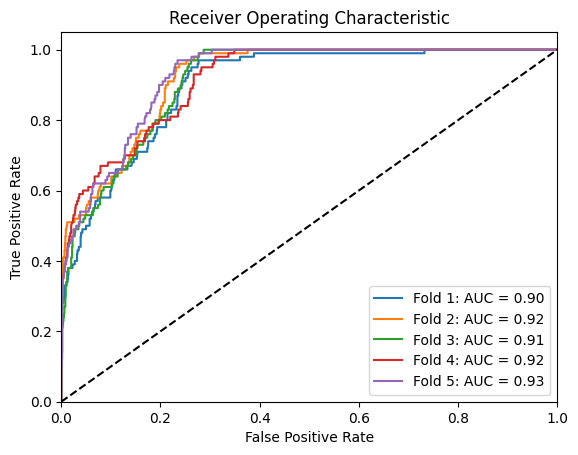

Average MCC: 0.6002239412968219
Average Recall: 0.584
Average Precision: 0.597736979518266
Average Accuracy: 0.6319262511412426
Average F1 Score: 0.5821714158558122
Average ROC AUC: 0.914925242849678


In [ ]:
for train_index, test_index in exp_skf.split(exp_X_vectorized_sampled, exp_y_sampled):
    exp_X_train, exp_X_test = exp_X_vectorized_sampled[train_index], exp_X_vectorized_sampled[test_index]
    exp_y_train, exp_y_test = exp_y_sampled.iloc[train_index], exp_y_sampled.iloc[test_index]

    exp_class_weights = {class_label: 1 for class_label in np.unique(exp_y_train)}
    exp_class_weights.update({class_label: 2 for class_label in np.unique(exp_y_train) if np.sum(exp_y_train == class_label) < len(exp_y_train) / len(np.unique(exp_y_train))})

    exp_model = LogisticRegression(class_weight=exp_class_weights, max_iter=1000)
    exp_model.fit(exp_X_train, exp_y_train)
    exp_predictions = exp_model.predict(exp_X_test)

    all_exp_y_test.extend(exp_y_test)
    all_exp_predictions.extend(exp_predictions)

    # ROC curve
    exp_probas = exp_model.predict_proba(exp_X_test)[:, 1]
    exp_fpr, exp_tpr, _ = roc_curve(exp_y_test, exp_probas, pos_label=exp_model.classes_[1])
    exp_roc_auc = auc(exp_fpr, exp_tpr)
    exp_roc_auc_scores.append(exp_roc_auc)

    # metrics
    exp_mcc_scores.append(matthews_corrcoef(exp_y_test, exp_predictions))
    exp_recall_scores.append(recall_score(exp_y_test, exp_predictions, average='macro'))
    exp_precision_scores.append(precision_score(exp_y_test, exp_predictions, average='macro', zero_division=0))
    exp_accuracy_scores.append(accuracy_score(exp_y_test, exp_predictions))
    exp_f1_scores.append(f1_score(exp_y_test, exp_predictions, average='macro'))

    plt.plot(exp_fpr, exp_tpr, label=f'Fold {len(exp_roc_auc_scores)}: AUC = {exp_roc_auc:.2f}')

# ROC curve plotting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Average MCC: {np.mean(exp_mcc_scores)}")
print(f"Average Recall: {np.mean(exp_recall_scores)}")
print(f"Average Precision: {np.mean(exp_precision_scores)}")
print(f"Average Accuracy: {np.mean(exp_accuracy_scores)}")
print(f"Average F1 Score: {np.mean(exp_f1_scores)}")
print(f"Average ROC AUC: {np.mean(exp_roc_auc_scores)}")


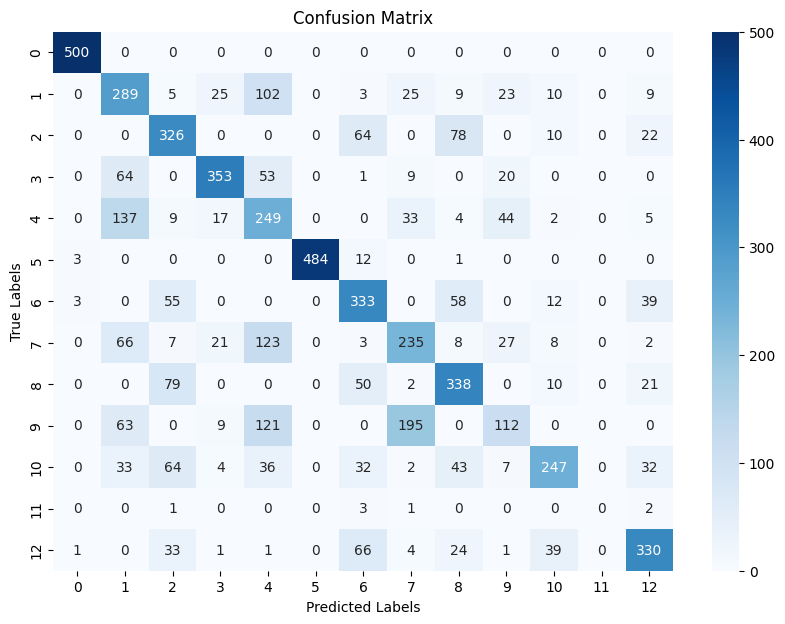

In [ ]:
# confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(all_exp_y_test, all_exp_predictions)

#### **LSTM (with improved Features)**

Epoch 1/5
61/61 [==============================] - 251s 4s/step - loss: 1.7960 - accuracy: 0.3939
Epoch 2/5
61/61 [==============================] - 237s 4s/step - loss: 1.3342 - accuracy: 0.5148
Epoch 3/5
61/61 [==============================] - 236s 4s/step - loss: 1.2292 - accuracy: 0.5611
Epoch 4/5
61/61 [==============================] - 232s 4s/step - loss: 1.1055 - accuracy: 0.6084
Epoch 5/5
94/94 [==============================] - 39s 407ms/step
Epoch 1/5
61/61 [==============================] - 233s 4s/step - loss: 1.2351 - accuracy: 0.5626
Epoch 2/5
61/61 [==============================] - 234s 4s/step - loss: 1.0242 - accuracy: 0.6441
Epoch 3/5
61/61 [==============================] - 236s 4s/step - loss: 0.8930 - accuracy: 0.6971
Epoch 4/5
61/61 [==============================] - 237s 4s/step - loss: 0.8066 - accuracy: 0.7237
Epoch 5/5
94/94 [==============================] - 37s 387ms/step


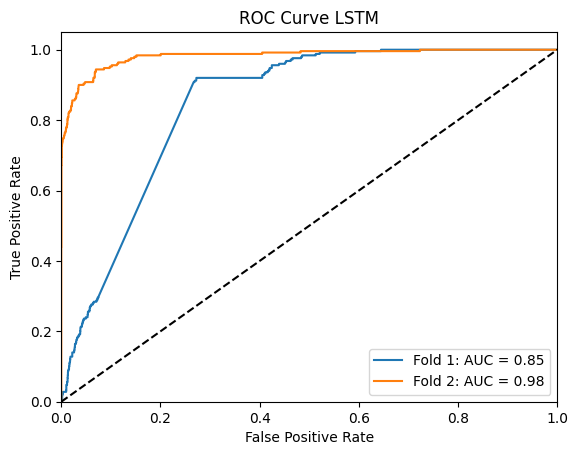

LSTM Average MCC: 0.6544623660701876
LSTM Average Recall: 0.622
LSTM Average Precision: 0.7019985473192244
LSTM Average Accuracy: 0.6730631773907406
LSTM Average F1 Score: 0.6159778242414843
LSTM Average ROC AUC: 0.9143714651027031


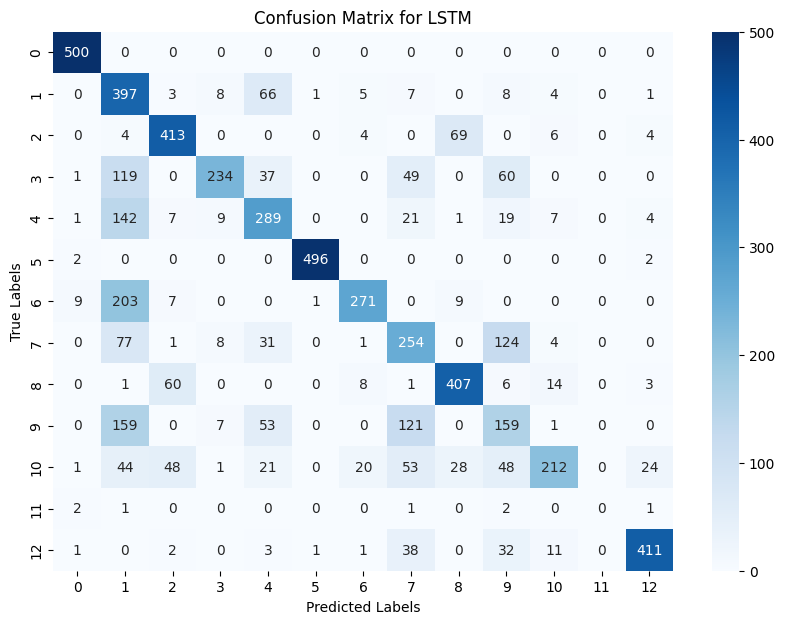

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, GRU, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from sklearn.metrics import matthews_corrcoef, recall_score, precision_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Assuming 'sampled_df' has the columns 'Token' and 'Label'
X_exp_lstm_sampled = sampled_df['Token'].tolist()
y_exp_lstm_sampled = sampled_df['Label'].tolist()

# Tokenization and sequence padding
tokenizer_exp_lstm = Tokenizer()
tokenizer_exp_lstm.fit_on_texts(X_exp_lstm_sampled)
X_exp_tokenized_lstm = tokenizer_exp_lstm.texts_to_sequences(X_exp_lstm_sampled)
X_exp_padded_lstm = pad_sequences(X_exp_tokenized_lstm, maxlen=300)  # Adjusted maxlen if necessary

# Preparing embedding matrix
embedding_dim = 100  # Correct dimension matching GloVe file
num_tokens_exp_lstm = len(tokenizer_exp_lstm.word_index) + 1
embedding_matrix_exp_lstm = np.zeros((num_tokens_exp_lstm, embedding_dim))
for word, i in tokenizer_exp_lstm.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_exp_lstm[i] = embedding_vector

# Label encoding
encoder_exp_lstm = LabelEncoder()
y_exp_encoded_lstm = encoder_exp_lstm.fit_transform(y_exp_lstm_sampled)
y_exp_categorical_lstm = to_categorical(y_exp_encoded_lstm)

# Model definition
model_exp_lstm = Sequential([
    Embedding(num_tokens_exp_lstm, embedding_dim, embeddings_initializer=Constant(embedding_matrix_exp_lstm), input_length=300, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(GRU(150, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(GRU(100, dropout=0.3, recurrent_dropout=0.3)),
    Dense(len(np.unique(y_exp_encoded_lstm)), activation='softmax')
])
model_exp_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Stratified K-Fold setup
skf_exp_lstm = StratifiedKFold(n_splits=2)
mcc_scores_exp_lstm, recall_scores_exp_lstm, precision_scores_exp_lstm, accuracy_scores_exp_lstm, f1_scores_exp_lstm, roc_auc_scores_exp_lstm = [], [], [], [], [], []

all_y_true, all_y_pred = [], []  # Collect all labels and predictions for the confusion matrix

for train_index, test_index in skf_exp_lstm.split(X_exp_padded_lstm, y_exp_encoded_lstm):
    X_train_exp_lstm, X_test_exp_lstm = X_exp_padded_lstm[train_index], X_exp_padded_lstm[test_index]
    y_train_exp_lstm, y_test_exp_lstm = y_exp_categorical_lstm[train_index], y_exp_categorical_lstm[test_index]

    model_exp_lstm.fit(X_train_exp_lstm, y_train_exp_lstm, epochs=5, batch_size=50, verbose=1)

    probabilities_exp_lstm = model_exp_lstm.predict(X_test_exp_lstm)
    predictions_exp_lstm = probabilities_exp_lstm.argmax(axis=1)
    y_test_argmax_exp_lstm = y_test_exp_lstm.argmax(axis=1)

    all_y_true.extend(y_test_argmax_exp_lstm)
    all_y_pred.extend(predictions_exp_lstm)

    mcc_scores_exp_lstm.append(matthews_corrcoef(y_test_argmax_exp_lstm, predictions_exp_lstm))
    recall_scores_exp_lstm.append(recall_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro'))
    precision_scores_exp_lstm.append(precision_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro', zero_division=0))
    accuracy_scores_exp_lstm.append(accuracy_score(y_test_argmax_exp_lstm, predictions_exp_lstm))
    f1_scores_exp_lstm.append(f1_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro'))

    fpr_exp_lstm, tpr_exp_lstm, _ = roc_curve(y_test_argmax_exp_lstm, probabilities_exp_lstm[:, 1], pos_label=1)
    roc_auc_exp_lstm = auc(fpr_exp_lstm, tpr_exp_lstm)
    roc_auc_scores_exp_lstm.append(roc_auc_exp_lstm)

    plt.plot(fpr_exp_lstm, tpr_exp_lstm, label=f'Fold {len(roc_auc_scores_exp_lstm)}: AUC = {roc_auc_exp_lstm:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LSTM')
plt.legend(loc="lower right")
plt.show()

print(f"LSTM Average MCC: {np.mean(mcc_scores_exp_lstm)}")
print(f"LSTM Average Recall: {np.mean(recall_scores_exp_lstm)}")
print(f"LSTM Average Precision: {np.mean(precision_scores_exp_lstm)}")
print(f"LSTM Average Accuracy: {np.mean(accuracy_scores_exp_lstm)}")
print(f"LSTM Average F1 Score: {np.mean(f1_scores_exp_lstm)}")
print(f"LSTM Average ROC AUC: {np.mean(roc_auc_scores_exp_lstm)}")

# Plot the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Load GloVe Word embeddings
exp_glove_path = base_path + '/glove.6B/glove.6B.100d.txt'

exp_embeddings_index = {}
with open(exp_glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        exp_embeddings_index[word] = coefs

In [ ]:
X_exp_lstm_sampled = exp_sampled_df['Token'].tolist()
y_exp_lstm_sampled = exp_sampled_df['Label'].tolist()

In [ ]:
tokenizer_exp_lstm = Tokenizer()
tokenizer_exp_lstm.fit_on_texts(X_exp_lstm_sampled)
X_exp_tokenized_lstm = tokenizer_exp_lstm.texts_to_sequences(X_exp_lstm_sampled)
X_exp_padded_lstm = pad_sequences(X_exp_tokenized_lstm, maxlen=300)



In [ ]:
# Embedding matrix
embedding_dim = 100
num_tokens_exp_lstm = len(tokenizer_exp_lstm.word_index) + 1
embedding_matrix_exp_lstm = np.zeros((num_tokens_exp_lstm, embedding_dim))
for word, i in tokenizer_exp_lstm.word_index.items():
    embedding_vector = exp_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_exp_lstm[i] = embedding_vector

In [ ]:
# Label encoding
encoder_exp_lstm = LabelEncoder()
y_exp_encoded_lstm = encoder_exp_lstm.fit_transform(y_exp_lstm_sampled)
y_exp_categorical_lstm = to_categorical(y_exp_encoded_lstm)

In [ ]:
# LSTM Model
model_exp_lstm = Sequential([
    Embedding(num_tokens_exp_lstm, embedding_dim, embeddings_initializer=Constant(embedding_matrix_exp_lstm), input_length=300, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(GRU(150, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(GRU(100, dropout=0.3, recurrent_dropout=0.3)),
    Dense(len(np.unique(y_exp_encoded_lstm)), activation='softmax')
])
model_exp_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Stratified K-Fold setup
skf_exp_lstm = StratifiedKFold(n_splits=5)
mcc_scores_exp_lstm, recall_scores_exp_lstm, precision_scores_exp_lstm, accuracy_scores_exp_lstm, f1_scores_exp_lstm, roc_auc_scores_exp_lstm = [], [], [], [], [], []

all_y_true, all_y_pred = [], []

Epoch 1/5
97/97 [==============================] - 258s 3s/step - loss: 1.6767 - accuracy: 0.4166
Epoch 2/5
97/97 [==============================] - 241s 2s/step - loss: 1.2798 - accuracy: 0.5265
Epoch 3/5
97/97 [==============================] - 240s 2s/step - loss: 1.1559 - accuracy: 0.5838
Epoch 4/5
97/97 [==============================] - 240s 2s/step - loss: 0.9807 - accuracy: 0.6524
Epoch 5/5
38/38 [==============================] - 15s 379ms/step
Epoch 1/5
97/97 [==============================] - 240s 2s/step - loss: 0.8535 - accuracy: 0.7086
Epoch 2/5
97/97 [==============================] - 243s 3s/step - loss: 0.7011 - accuracy: 0.7692
Epoch 3/5
97/97 [==============================] - 240s 2s/step - loss: 0.6100 - accuracy: 0.7929
Epoch 4/5
97/97 [==============================] - 240s 2s/step - loss: 0.5575 - accuracy: 0.8054
Epoch 5/5
38/38 [==============================] - 14s 379ms/step
Epoch 1/5
97/97 [==============================] - 240s 2s/step - loss: 0.5247 - acc

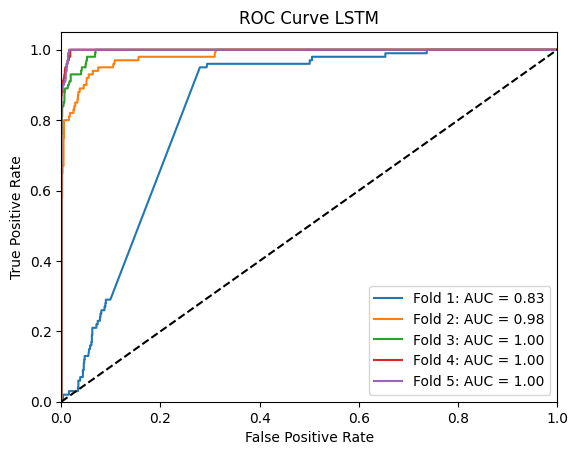

LSTM Average MCC: 0.7922225445540583
LSTM Average Recall: 0.758153846153846
LSTM Average Precision: 0.7980083157046504
LSTM Average Accuracy: 0.803925874306076
LSTM Average F1 Score: 0.7593539434446891
LSTM Average ROC AUC: 0.9617019975241119


In [ ]:
for train_index, test_index in skf_exp_lstm.split(X_exp_padded_lstm, y_exp_encoded_lstm):
    X_train_exp_lstm, X_test_exp_lstm = X_exp_padded_lstm[train_index], X_exp_padded_lstm[test_index]
    y_train_exp_lstm, y_test_exp_lstm = y_exp_categorical_lstm[train_index], y_exp_categorical_lstm[test_index]

    model_exp_lstm.fit(X_train_exp_lstm, y_train_exp_lstm, epochs=5, batch_size=50, verbose=1)

    probabilities_exp_lstm = model_exp_lstm.predict(X_test_exp_lstm)
    predictions_exp_lstm = probabilities_exp_lstm.argmax(axis=1)
    y_test_argmax_exp_lstm = y_test_exp_lstm.argmax(axis=1)

    all_y_true.extend(y_test_argmax_exp_lstm)
    all_y_pred.extend(predictions_exp_lstm)

    mcc_scores_exp_lstm.append(matthews_corrcoef(y_test_argmax_exp_lstm, predictions_exp_lstm))
    recall_scores_exp_lstm.append(recall_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro'))
    precision_scores_exp_lstm.append(precision_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro', zero_division=0))
    accuracy_scores_exp_lstm.append(accuracy_score(y_test_argmax_exp_lstm, predictions_exp_lstm))
    f1_scores_exp_lstm.append(f1_score(y_test_argmax_exp_lstm, predictions_exp_lstm, average='macro'))

    fpr_exp_lstm, tpr_exp_lstm, _ = roc_curve(y_test_argmax_exp_lstm, probabilities_exp_lstm[:, 1], pos_label=1)
    roc_auc_exp_lstm = auc(fpr_exp_lstm, tpr_exp_lstm)
    roc_auc_scores_exp_lstm.append(roc_auc_exp_lstm)

    plt.plot(fpr_exp_lstm, tpr_exp_lstm, label=f'Fold {len(roc_auc_scores_exp_lstm)}: AUC = {roc_auc_exp_lstm:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LSTM')
plt.legend(loc="lower right")
plt.show()

print(f"LSTM Average MCC: {np.mean(mcc_scores_exp_lstm)}")
print(f"LSTM Average Recall: {np.mean(recall_scores_exp_lstm)}")
print(f"LSTM Average Precision: {np.mean(precision_scores_exp_lstm)}")
print(f"LSTM Average Accuracy: {np.mean(accuracy_scores_exp_lstm)}")
print(f"LSTM Average F1 Score: {np.mean(f1_scores_exp_lstm)}")
print(f"LSTM Average ROC AUC: {np.mean(roc_auc_scores_exp_lstm)}")

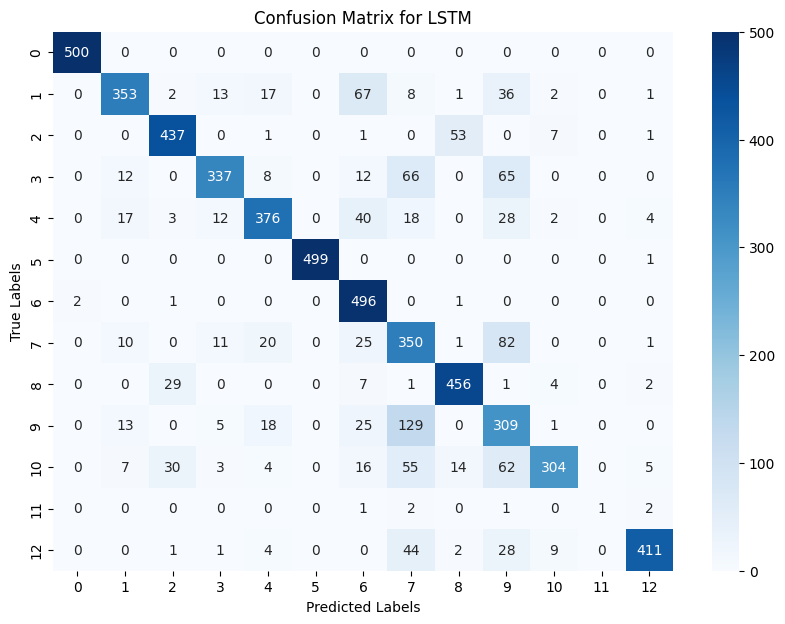

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Transformers: Deberta3Base Training

### Data Tokenization

In [ ]:
def tokenize(example, tokenizer, label2id, max_length):

    # rebuild text from tokens
    text = []
    labels = []

    for t, l, ws in zip(
        example["tokens"], example["provided_labels"], example["trailing_whitespace"]
    ):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    # actual tokenization
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

In [ ]:
TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
TRAINING_MAX_LENGTH = 1024
OUTPUT_DIR = "output"

In [ ]:
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("microsoft/deberta-v3-base")

In [ ]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)
ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})
ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Map (num_proc=3):   0%|          | 0/9333 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
x = ds[0]

for t,l in zip(x["tokens"], x["provided_labels"]):
    if l != "O":
        print((t,l))

print("*"*100)

for t, l in zip(tokenizer.convert_ids_to_tokens(x["input_ids"]), x["labels"]):
    if id2label[l] != "O":
        print((t,id2label[l]))

('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
****************************************************************************************************
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')


### Metrics

In [ ]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f1_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)

    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score
    }
    return results

### Deberta Training

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    TRAINING_MODEL_PATH,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split the data into training, validation, and test sets
train_test_data = ds.train_test_split(test_size=0.2, seed=42)
train_data = train_test_data["train"]
test_data = train_test_data["test"]

train_val_data = train_data.train_test_split(test_size=0.25, seed=42)
train_data = train_val_data["train"]
val_data = train_val_data["test"]

In [ ]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    fp16=True,
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    report_to="none",
    evaluation_strategy="epoch",
    do_eval=True,
    save_total_limit=1,
    logging_steps=20,
    lr_scheduler_type='cosine',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=partial(compute_metrics, all_labels=all_labels),
)

In [88]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Recall,Precision,F1
1,0.005900,0.005283,0.982396,0.985771,0.982525
2,0.002100,0.005096,0.985622,0.985929,0.985634
3,0.001700,0.004880,0.986669,0.986306,0.986655


CPU times: user 26min 59s, sys: 6min 45s, total: 33min 45s
Wall time: 33min 44s


TrainOutput(global_step=2100, training_loss=0.003565609807237273, metrics={'train_runtime': 2023.8907, 'train_samples_per_second': 8.299, 'train_steps_per_second': 1.038, 'total_flos': 6363291018572928.0, 'train_loss': 0.003565609807237273, 'epoch': 3.0})

In [89]:
# Saving model for inference
trainer.save_model("models/deberta3base_1024_main_v4")
tokenizer.save_pretrained("models/deberta3base_1024_main_v4")

('models/deberta3base_1024_main_v4/tokenizer_config.json',
 'models/deberta3base_1024_main_v4/special_tokens_map.json',
 'models/deberta3base_1024_main_v4/spm.model',
 'models/deberta3base_1024_main_v4/added_tokens.json',
 'models/deberta3base_1024_main_v4/tokenizer.json')

In [90]:
base_path = '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/'

# Saving model for inference
trainer.save_model(base_path+"models/deberta3base_1024_main_v4")
tokenizer.save_pretrained(base_path+"models/deberta3base_1024_main_v4")

('/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/models/deberta3base_1024_main_v4/tokenizer_config.json',
 '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/models/deberta3base_1024_main_v4/special_tokens_map.json',
 '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/models/deberta3base_1024_main_v4/spm.model',
 '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/models/deberta3base_1024_main_v4/added_tokens.json',
 '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/models/deberta3base_1024_main_v4/tokenizer.json')

In [91]:
validation_results = trainer.evaluate(eval_dataset=val_data)
print("Validation Results:", validation_results)

Validation Results: {'eval_loss': 0.004879966843873262, 'eval_recall': 0.986669308275784, 'eval_precision': 0.9863064082614231, 'eval_f1': 0.9866553456449445, 'eval_runtime': 78.0225, 'eval_samples_per_second': 23.929, 'eval_steps_per_second': 2.999, 'epoch': 3.0}


In [92]:
test_results = trainer.evaluate(eval_dataset=test_data)
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.004721636883914471, 'eval_recall': 0.9865217638045514, 'eval_precision': 0.9864377925946943, 'eval_f1': 0.9865185338782817, 'eval_runtime': 82.2516, 'eval_samples_per_second': 22.699, 'eval_steps_per_second': 2.845, 'epoch': 3.0}


In [96]:
output = trainer.predict(test_data)
predictions = output.predictions

predictions = np.argmax(predictions, axis=2)

true_labels = []
pred_labels = []
for label_seq, pred_seq in zip(test_data['labels'], predictions):
    seq_labels = []
    seq_preds = []
    for label, pred in zip(label_seq, pred_seq):
        if label != -100:
            seq_labels.append(label)
            seq_preds.append(pred)
    true_labels.extend(seq_labels)
    pred_labels.extend(seq_preds)


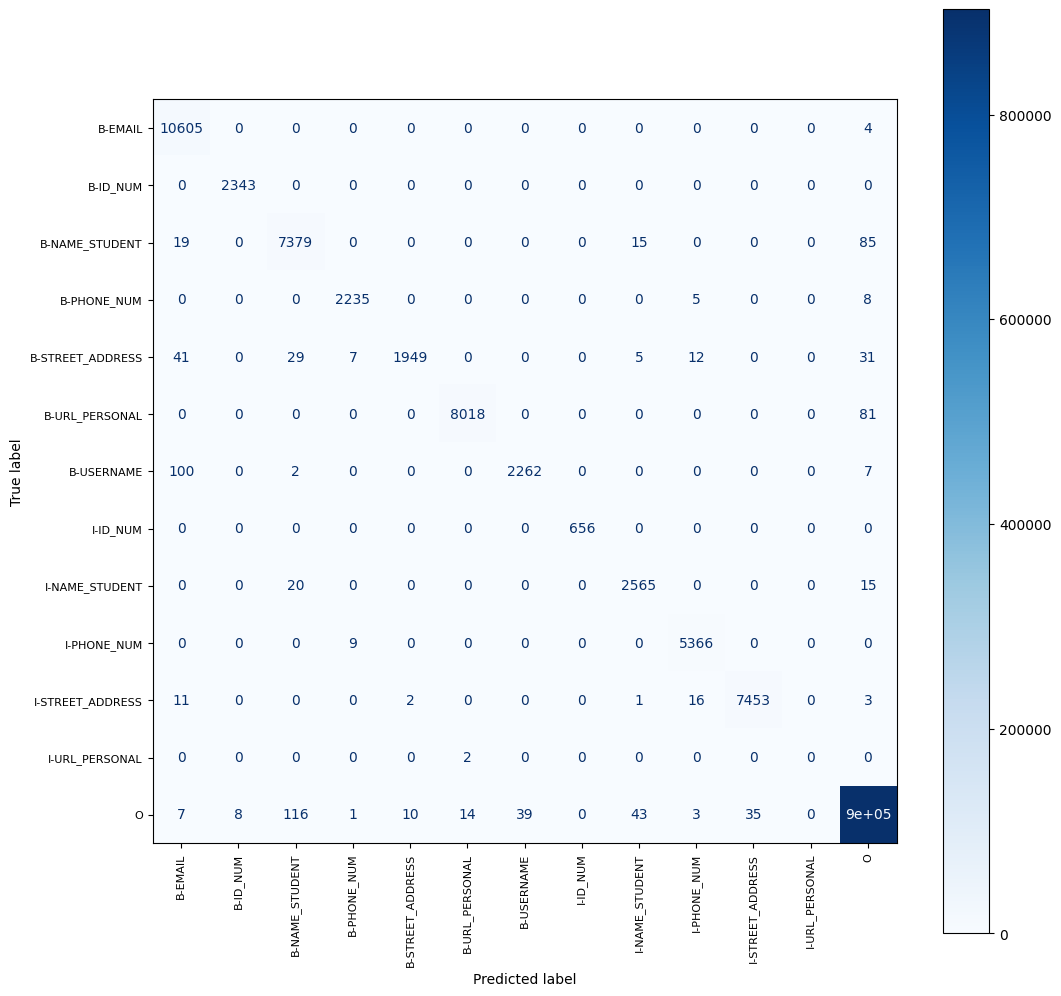

In [98]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
fig, ax = plt.subplots(figsize=(12,12))  # Adjust the figure size as needed
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')  # Rotate x-axis labels
plt.xticks(fontsize=8)  # Adjust font size as necessary
plt.yticks(fontsize=8)
plt.show()


In [101]:
from plotly.graph_objs import Scatter, Figure

train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

fig = Figure()
fig.add_trace(Scatter(x=list(range(len(train_loss))), y=train_loss, mode='lines+markers', name='Training Loss'))
fig.add_trace(Scatter(x=list(range(len(eval_loss))), y=eval_loss, mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


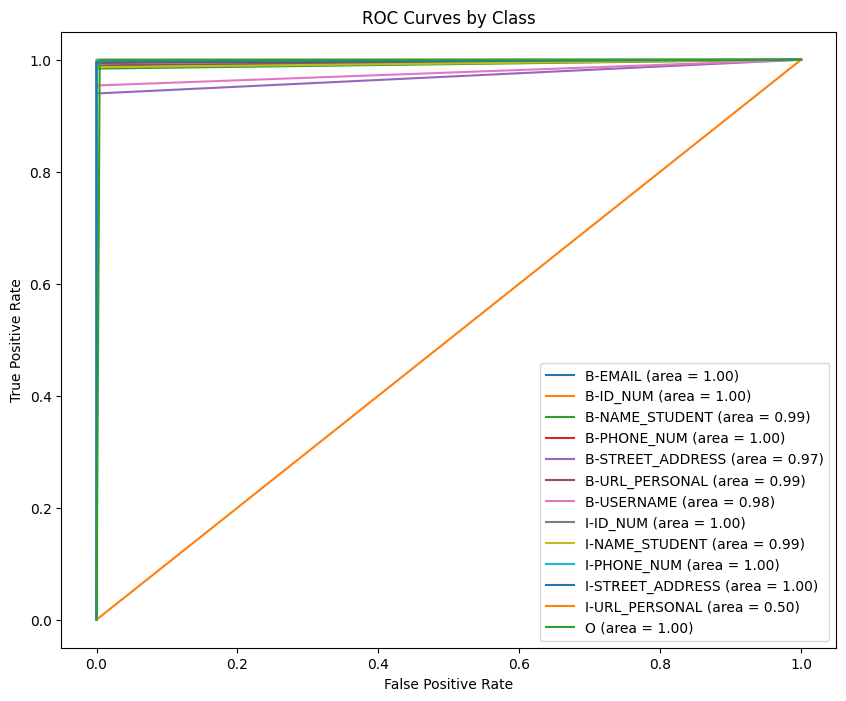

In [102]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for a one-vs-all setting
y_true_bin = label_binarize(true_labels, classes=list(range(len(all_labels))))
y_pred_bin = label_binarize(pred_labels, classes=list(range(len(all_labels))))

fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(all_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Class')
ax.legend(loc="best")
plt.show()

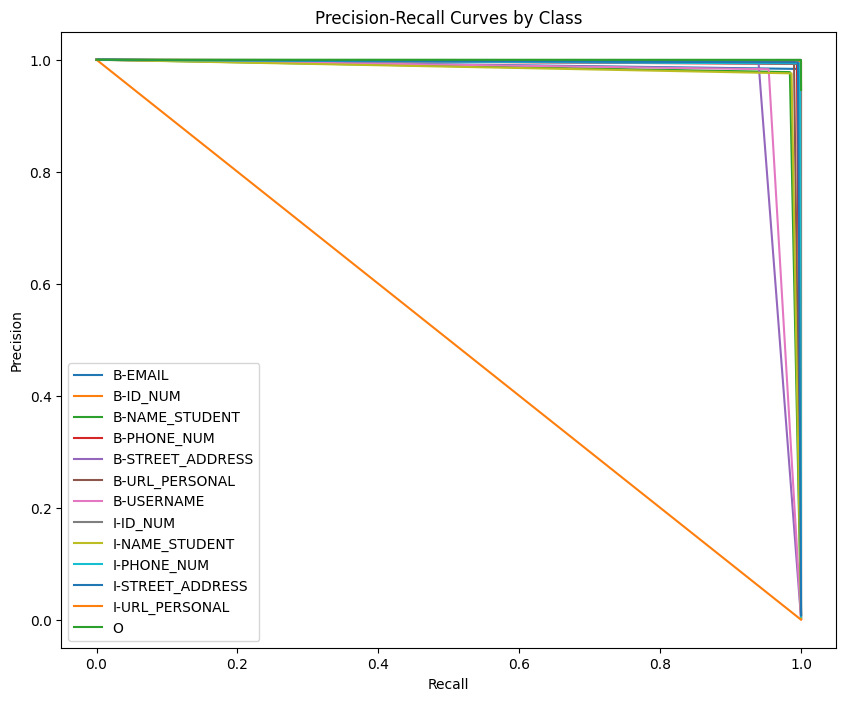

In [103]:
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(all_labels):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    ax.plot(recall, precision, label=f'{label}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves by Class')
ax.legend(loc="best")
plt.show()


### Deberta Testing

In [ ]:
import json
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from transformers import DataCollatorForTokenClassification

try:
    import google.colab
    IN_COLAB = True
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/'
except ImportError:
    IN_COLAB = False
    base_path = os.getcwd()

model_path = base_path + 'models/deberta3base_1024_main_v1'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

test_data_path = base_path + "datasets/test-v1.json"
test_data = json.load(open(test_data_path))

def tokenize(example, tokenizer, label2id):
    tokens = example["tokens"]
    text = " ".join(tokens)
    labels = example["labels"]

    tokenized_inputs = tokenizer(text, truncation=True, padding='max_length', max_length=128)
    tokenized_labels = []

    word_ids = tokenized_inputs.word_ids()  # Map tokens to their corresponding word.
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:  # Set labels according to word_ids
        if word_idx is None or word_idx != previous_word_idx:
            label_ids.append(label2id[labels[word_idx]] if word_idx is not None else -100)
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

all_labels = sorted(list(set([label for data in test_data for label in data["labels"]])))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

dataset = Dataset.from_dict(test_data)
tokenized_dataset = dataset.map(lambda x: tokenize(x, tokenizer, label2id))

collator = DataCollatorForTokenClassification(tokenizer)
args = TrainingArguments(
    output_dir="./results",
    do_train=False,
    do_predict=True,
    per_device_eval_batch_size=8,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=collator,
    tokenizer=tokenizer
)

predictions = trainer.predict(tokenized_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1).flatten()
true_labels = predictions.label_ids.flatten()

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(all_labels)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC curve (assuming binary classification for simplicity)
fpr, tpr, _ = roc_curve(true_labels, predicted_labels, pos_label=label2id['target_label'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel


## Inference

### Imports

In [ ]:
!pip install transformers datasets features sentencepiece torch tensorflow seqeval evaluate -q

In [ ]:
!pip install accelerate -U -q

In [ ]:
# !pip install transformers[torch]

In [ ]:
import json
import argparse
from itertools import chain
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
# from datasets import Dataset
import numpy as np
from google.colab import drive

from functools import partial
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
import evaluate
from datasets import Dataset, features
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.express as px
import random

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/MSCS-PROJECT/jupyter-notebooks/'
    model_path = base_path + 'models/deberta3base_1024_main_v1'
else:
    current_dir = os.getcwd()
    model_path = 'models/deberta3base_1024_main_v1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INFERENCE_MAX_LENGTH = 2048
# model_path = 'models/deberta3base_1024_main_v1'

### Data Loading & Tokenization

In [ ]:
def convert_to_json(text):
    json_structure = {
        "document": random.randint(1, 1000),
        "full_text": text,
        "tokens": text.split(),
        "trailing_whitespace": [char.isspace() for char in text]
    }
    return json_structure

texts = [
    "My name is Lovedeep Singh. I study at Rutgers Camden.\nI would like to study MS in Computer Science.",
    "My name is XYZ Singh. I study at Rutgers Camden.\nI would like to study MS in Computer Science. Author by Buzan and Soni.",
    "Title: The Impact of Digital Technology on Personal Privacy\n\nIn the digital age, the issue of personal privacy has become increasingly significant. As individuals, we often share our personal information without fully understanding the potential repercussions. Consider the story of John Doe, a 35-year-old software developer from Springfield, Illinois. John, born on May 15, 1987, and holding a Social Security number of 123-45-6789, has always been an advocate for digital innovations.\n\nRecently, Jane Smith, a 29-year-old marketing manager from Dallas, Texas, shared a similar concern. Jane, whose driver’s license number is TX-2001-123-4567, has noticed an uptick in unsolicited emails and phone calls after signing up for various online services. Her email address, jane.smith@example.com, and phone number, (214) 555-0187, seem to have been shared across multiple platforms without her explicit consent.\n\nThe story is the same for Michael Johnson, a 42-year-old teacher from Miami, Florida. Michael's passport number, USA9876543, was leaked during an online booking for an international conference. Such incidents highlight the need for stricter regulations to protect sensitive information.\n\nIn conclusion, while technology offers numerous benefits, it also poses significant risks to personal privacy. It is crucial for legislation to catch up with technological advancements to ensure that personal information, such as that of John, Jane, and Michael, remains secure in the digital ecosystem.",
    "Title: Navigating the Challenges of Cybersecurity in Modern Enterprises\n\n Authored by Prof. Desmund Lun \n\nAs enterprises continue to expand their digital footprints, the importance of robust cybersecurity measures becomes increasingly evident. One notable instance involves Alex Turner, a cybersecurity analyst from New York City, who detected a significant breach in his company's data infrastructure. Alex, born on June 12, 1990, with a Social Security number of 234-56-7890, successfully mitigated the attack, which targeted sensitive employee data, including his own, such as his driver’s license number NY-2002-234-5678.\n\nAccording to a study by Thompson et al. (2020), the frequency of cyber-attacks has risen by 40% over the last two years, underscoring the urgency for advanced protective strategies. This statistic aligns with the experiences of Sarah Lee, a 32-year-old financial analyst from San Francisco, whose bank account details (Account No: 123456789, Bank: Bank of San Francisco) were compromised last month. Her email, sarah.lee@example.com, was also involved in a phishing scam, revealing the sophisticated tactics employed by cybercriminals.\n\nAs the author concludes, 'The digital transformation journey of many companies has accelerated, but so has the sophistication of threats they face. It is imperative that businesses invest more in their cybersecurity infrastructures to protect assets like those of Alex and Sarah.'\n\nIn summary, as the digital landscape evolves, so too must our approaches to cybersecurity. Protecting sensitive information and thwarting cyber threats must be a top priority for modern enterprises (Thompson et al., 2020)."
]

json_objects = [convert_to_json(text) for text in texts]

if IN_COLAB:
  with open(base_path + '/inference/test-main.json', 'w') as json_file:
    json.dump(json_objects, json_file, indent=4)
else:
    with open('/content/test-main.json', 'w') as json_file:
      json.dump(json_objects, json_file, indent=4)

In [ ]:
def tokenize(example, tokenizer):
    text = []
    token_map = []

    idx = 0

    for t, ws in zip(example["tokens"], example["trailing_whitespace"]):

        text.append(t)
        token_map.extend([idx]*len(t))
        if ws:
            text.append(" ")
            token_map.append(-1)

        idx += 1


    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=True, max_length=INFERENCE_MAX_LENGTH)


    return {
        **tokenized,
        "token_map": token_map,
    }

In [ ]:
# data = json.load(open("test.json"))

def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

if IN_COLAB:
    data1 = load_json(base_path + "/inference/test-main.json")
    # data2 = load_json(base_path + "/datasets/test.json")
else:
    data1 = load_json("/content/test-main.json")
    # data2 = load_json("/content/test.json")

# data = data1 + data2

data = data1

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [x["document"] for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
})

tokenizer = AutoTokenizer.from_pretrained(model_path)
ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer}, num_proc=2)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Map (num_proc=2):   0%|          | 0/4 [00:00<?, ? examples/s]

### Use Trained Model to Predict PII Data

---



In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_path)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)
args = TrainingArguments(
    ".",
    per_device_eval_batch_size=1,
    report_to="none",
)
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collator,
    tokenizer=tokenizer,
)

In [ ]:
predictions = trainer.predict(ds).predictions
pred_softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis = 2).reshape(predictions.shape[0],predictions.shape[1],1)

config = json.load(open(Path(model_path) / "config.json"))
id2label = config["id2label"]
preds = predictions.argmax(-1)
preds_without_O = pred_softmax[:,:,:12].argmax(-1)
O_preds = pred_softmax[:,:,12]

threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O , preds)

In [ ]:
triplets = []
document, token, label, token_str = [], [], [], []
for p, token_map, offsets, tokens, doc in zip(preds_final, ds["token_map"], ds["offset_mapping"], ds["tokens"], ds["document"]):

    for token_pred, (start_idx, end_idx) in zip(p, offsets):
        label_pred = id2label[str(token_pred)]

        if start_idx + end_idx == 0: continue

        if token_map[start_idx] == -1:
            start_idx += 1

        # ignore "\n\n"
        while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
            start_idx += 1

        if start_idx >= len(token_map): break

        token_id = token_map[start_idx]

        # ignore "O" predictions and whitespace preds
        if label_pred != "O" and token_id != -1:
            triplet = (label_pred, token_id, tokens[token_id])

            if triplet not in triplets:
                document.append(doc)
                token.append(token_id)
                label.append(label_pred)
                token_str.append(tokens[token_id])
                triplets.append(triplet)

In [ ]:
df = pd.DataFrame({
    "document": document,
    "token": token,
    "label": label,
    "token_str": token_str
})
df["row_id"] = list(range(len(df)))
display(df.head(100))

,document,token,label,token_str,row_id
0,913,3,B-NAME_STUDENT,Lovedeep,0
1,913,4,I-NAME_STUDENT,Singh.,1
2,968,3,B-NAME_STUDENT,XYZ,2
3,555,49,B-NAME_STUDENT,"John,",3
4,555,62,B-ID_NUM,"123-45-6789,",4
5,555,62,I-ID_NUM,"123-45-6789,",5
6,555,91,B-ID_NUM,"TX-2001-123-4567,",6
7,555,91,I-ID_NUM,"TX-2001-123-4567,",7
8,555,112,B-EMAIL,"jane.smith@example.com,",8
9,555,116,B-PHONE_NUM,(214),9


In [ ]:
# df[["row_id", "document", "token", "token_str", "label"]].to_csv("outputs/output_deberta_main_v1.csv", index=False)

# Further Experiments

### Understanding Metrics

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

In [ ]:
def F_beta(P, R, beta):
    return (1 + beta**2) * P * R / (beta** 2 * P + R)

P = np.linspace(1e-3, 1, 100)
R = np.linspace(1e-3, 1, 100)
beta = np.concatenate((np.linspace(0, 0.95, 10), [1], np.linspace(1.05, 5, 10)))

list_df = [
    pd.DataFrame(data={
        "P": P,
        "R": R,
        "F_beta": [
            F_beta(P, R_i, beta_i) for R_i in R
        ],
    })
    for beta_i in beta
]

# ---> Plot
print()

# Initial index of beta considered in the animation
i = 10

# Plotly GO (Graph Objects) figure
fig = go.Figure()

# Contour plot
fig.add_trace(go.Contour(
        x=list_df[i]["P"],
        y=list_df[i]["R"],
        z=list_df[i]["F_beta"],
        colorscale="Bluyl",
        contours=dict(
            coloring="fill",
            showlabels = True,
            labelfont = dict(
                size = 12,
                color = "black",
            )
        ),
        colorbar=dict(
            title=r"F",
            titleside="top",
            titlefont=dict(size=14),
            outlinewidth=1,
            thickness=30,
            thicknessmode="pixels",
            len=0.9,
            lenmode="fraction",
            nticks=10,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            showticklabels=True,
            tickangle=0,
            tickfont_size=12,
        ),
    )
)

fig.update_layout(
    # Figure dimensions
    width=700,
    height=700,

    # Template
    template="simple_white",

    # Margins
    margin=dict(l=50, r=50, t=50, b=50),

    # Font family
    font_family="Serif",

    # Title
    title=dict(
        text=r"$\large\text{Dependence of }F\text{ on }R\text{ and }P$",
        x=0.5,
        y=1,
        font=dict(size=20),
        pad=dict(t=20, b=20)
    ),

    # Axes titles
    xaxis_title=dict(text=r"$\mathrm{Precision},\,P$", font=dict(size=12)),
    yaxis_title=dict(text=r"$\mathrm{Recall},\,R$", font=dict(size=12)),

    # Axes
    xaxis=dict(
        showline=True,
        linecolor="black",
        linewidth=1,
        mirror=True,
        # Used together with xaxis' scaleanchor="x"  to make the aspect ratio of the
        # axes be 1
        constrain="domain",
    ),
    yaxis=dict(
        showline=True,
        linecolor="black",
        linewidth=1,
        mirror=True,
        scaleanchor="x"
    ),

    # Slider
    sliders=[dict(
        # Padding
        pad=dict(t=50),
        # Index of the list of steps to consider at start
        active=i,
        # Format for current slider value
        currentvalue=dict(prefix=r"beta = ", font=dict(size=14)),
        steps=[dict(
                # Text label that appears in the slider
                label=f"{beta[j]:.2f}",
                # Slider method
                method="animate",
                # List of arguments for method
                args=[
                    # Frame name
                    [str(j)],
                    # Options
                    dict(frame=dict(duration=200), mode="immediate", easing="cubic-in-out")]
        ) for j in range(len(list_df))]
    )]
)

# List frames for animation
frames = [
    # The updating data (each object sorted according to the order of trace addition)
    go.Frame(
        # Frame name (needs to be the same as the one considered in sliders' steps)
        name=str(i),
        # Frame data
        data=[
            go.Contour(
                x=list_df[i]["P"],
                y=list_df[i]["R"],
                z=list_df[i]["F_beta"],
            )
        ],
) for i in range(len(list_df))]

# Add frames to the animation
fig.frames = frames

# Show plot
fig.show()


Output hidden; open in https://colab.research.google.com to view.